In [1]:
import jax
import jax.numpy as jnp
from chewc.population import msprime_pop

# Set parameters
pop_size = 500
h2 = 0.4  # Note: h2 will be used later for phenotyping, not in msprime_pop directly
n_chr = 5
n_loci_per_chr = 100

# Initialize JAX random key
key = jax.random.PRNGKey(42)

# Create founder population using msprime coalescent simulation
founder_pop, genetic_map = msprime_pop(
    key=key,
    n_ind=pop_size,
    n_loci_per_chr=n_loci_per_chr,
    n_chr=n_chr,
    ploidy=2,  # Default diploid
    effective_population_size=1_000,  # Default from function
    mutation_rate=2e-8,  # Default from function
    recombination_rate_per_chr=2e-8,  # Default from function
    maf_threshold=0.1,  # Default from function
)

# Display basic information about the simulated population
print(f"Created population: {founder_pop}")
print(f"Population size: {founder_pop.nInd}")
print(f"Number of chromosomes: {founder_pop.nChr}")
print(f"Genotype array shape: {founder_pop.geno.shape}")
print(f"Genetic map shape: {genetic_map.shape}")

# Check some basic properties
print(f"\nPopulation properties:")
print(f"- Sex distribution: {jnp.bincount(founder_pop.sex)}")
print(f"- Dosage matrix shape: {founder_pop.dosage.shape}")
print(f"- Haplotype matrix shape: {founder_pop.haplo_matrix.shape}")

# The h2 parameter you specified (0.4) will be used later when adding traits
# and setting phenotypes, not directly in the msprime_pop function
print(f"\nNote: h2={h2} will be used when adding traits and phenotypes to this population.")

Created population: Population(nInd=500, nTraits=0, has_ebv=No)
Population size: 500
Number of chromosomes: 5
Genotype array shape: (500, 5, 2, 100)
Genetic map shape: (5, 100)

Population properties:
- Sex distribution: [233 267]
- Dosage matrix shape: (500, 500)
- Haplotype matrix shape: (1000, 500)

Note: h2=0.4 will be used when adding traits and phenotypes to this population.


MAF Summary Statistics:
  mean_maf: 0.26193201541900635
  median_maf: 0.2460000067949295
  min_maf: 0.09399999678134918
  max_maf: 0.49699997901916504
  std_maf: 0.10752320289611816
  n_loci: 500
  n_monomorphic: 0


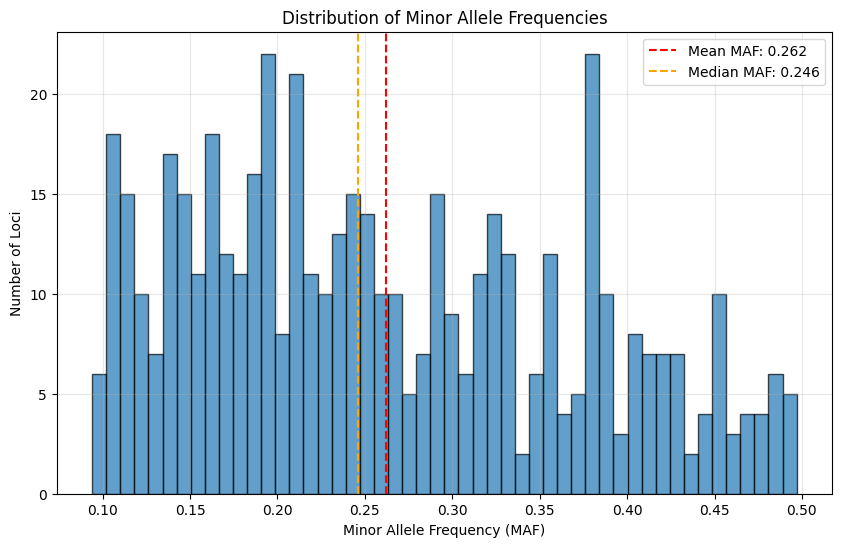

In [4]:
import jax
import jax.numpy as jnp
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a

# Parameters from previous step
pop_size = 500
h2 = 0.4
n_chr = 5
n_loci_per_chr = 100

# Initialize JAX random key
key = jax.random.PRNGKey(42)

# Create founder population (from previous step)
key, pop_key = jax.random.split(key)
founder_pop, genetic_map = msprime_pop(
    key=pop_key,
    n_ind=pop_size,
    n_loci_per_chr=n_loci_per_chr,
    n_chr=n_chr
)

print(f"Created founder population: {founder_pop}")
print(f"Genetic map shape: {genetic_map.shape}")

# Create SimParam object from the founder population
sim_param = SimParam.from_founder_pop(
    founder_pop=founder_pop,
    gen_map=genetic_map
)

print(f"Created SimParam: {sim_param}")

# Add additive trait using ALL available loci as QTL
# Since we want all loci as QTL, n_qtl_per_chr = n_loci_per_chr
key, trait_key = jax.random.split(key)

# Trait parameters
mean = jnp.array([10.0])  # Mean of 10
var = jnp.array([2.0])    # Variance of 2
n_qtl_per_chr = n_loci_per_chr  # Use all 100 loci per chromosome as QTL

# Add the additive trait
sim_param_with_trait = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sim_param,
    n_qtl_per_chr=n_qtl_per_chr,
    mean=mean,
    var=var,
    cor_a=None,  # No correlation (single trait)
    gamma=False,  # Use normal distribution for effects
    shape=1.0     # Not used when gamma=False
)

print(f"Updated SimParam with trait: {sim_param_with_trait}")
print(f"Number of traits: {sim_param_with_trait.n_traits}")

# Check the trait details
if sim_param_with_trait.traits is not None:
    print(f"Trait collection:")
    print(f"  - Number of QTL: {sim_param_with_trait.traits.n_loci}")
    print(f"  - Total loci across all chromosomes: {n_chr * n_loci_per_chr}")
    print(f"  - Additive effects shape: {sim_param_with_trait.traits.add_eff.shape}")
    print(f"  - Intercept: {sim_param_with_trait.traits.intercept}")
    print(f"  - Effect sizes - mean: {jnp.mean(jnp.abs(sim_param_with_trait.traits.add_eff)):.6f}")
    print(f"  - Effect sizes - std: {jnp.std(sim_param_with_trait.traits.add_eff):.6f}")

print(f"\nNext step: Use set_pheno() to generate phenotypes with h2={h2}")

Created founder population: Population(nInd=500, nTraits=0, has_ebv=No)
Genetic map shape: (5, 100)
Created SimParam: SimParam(nChr=5, nTraits=0, ploidy=2, sexes='no')
Updated SimParam with trait: SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')
Number of traits: 1
Trait collection:
  - Number of QTL: 500
  - Total loci across all chromosomes: 500
  - Additive effects shape: (1, 500)
  - Intercept: [9.37842]
  - Effect sizes - mean: 0.072594
  - Effect sizes - std: 0.091371

Next step: Use set_pheno() to generate phenotypes with h2=0.4


In [8]:
import jax
import jax.numpy as jnp
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.cross import make_cross
from chewc.phenotype import set_pheno

def run_burnin(key, founder_pop, sim_param, n_generations=20, pop_size=500, 
               use_pheno=False, h2=0.4):
    """
    Run burn-in for specified generations using random mating.
    
    Args:
        key: JAX random key
        founder_pop: Initial population
        sim_param: Simulation parameters
        n_generations: Number of burn-in generations
        pop_size: Population size to maintain
        use_pheno: If True, set phenotypes for each generation using set_pheno
        h2: Heritability to use when setting phenotypes (only used if use_pheno=True)
    
    Returns:
        Final population after burn-in
    """
    current_pop = founder_pop
    
    for gen in range(n_generations):
        print(f"Generation {gen + 1}/{n_generations}")
        
        # Split key for this generation
        key, gen_key = jax.random.split(key)
        cross_key, sex_key = jax.random.split(gen_key)
        
        # Create random mating plan
        # Sample parents randomly with replacement to allow multiple offspring per parent
        n_crosses = pop_size  # Maintain population size
        
        # Random parent selection for burn-in
        mother_indices = jax.random.choice(
            cross_key, current_pop.nInd, shape=(n_crosses,), replace=True
        )
        father_indices = jax.random.choice(
            jax.random.split(cross_key)[1], current_pop.nInd, shape=(n_crosses,), replace=True
        )
        
        # Create cross plan (using internal IDs)
        cross_plan = jnp.stack([mother_indices, father_indices], axis=1)
        
        # Calculate next ID start
        next_id_start = jnp.max(current_pop.id) + 1
        
        # Make crosses to create next generation
        next_pop = make_cross(
            key=cross_key,
            pop=current_pop,
            cross_plan=cross_plan,
            sp=sim_param,
            next_id_start=int(next_id_start)
        )
        
        # Optionally set phenotypes for the new generation
        if use_pheno and sim_param.traits is not None:
            key, pheno_key = jax.random.split(key)
            next_pop = set_pheno(
                key=pheno_key,
                pop=next_pop,
                traits=sim_param.traits,
                ploidy=sim_param.ploidy,
                h2=jnp.array([h2])
            )
            if gen % 5 == 0 or gen == n_generations - 1:
                print(f"  Phenotypes set with h2={h2}")
        
        # Update current population
        current_pop = next_pop
        
        # Print some basic stats
        if gen % 5 == 0 or gen == n_generations - 1:
            print(f"  Population size: {current_pop.nInd}")
            print(f"  ID range: {jnp.min(current_pop.id)} - {jnp.max(current_pop.id)}")
            if use_pheno and current_pop.pheno.shape[1] > 0:
                pheno_mean = jnp.mean(current_pop.pheno[:, 0])
                pheno_var = jnp.var(current_pop.pheno[:, 0])
                print(f"  Phenotype - mean: {pheno_mean:.3f}, var: {pheno_var:.3f}")
                if current_pop.bv is not None:
                    bv_var = jnp.var(current_pop.bv[:, 0])
                    realized_h2 = bv_var / pheno_var if pheno_var > 0 else 0
                    print(f"  Realized h2: {realized_h2:.3f}")
    
    return current_pop

# Set up the simulation (building on previous steps)
pop_size = 200
n_chr = 5
n_loci_per_chr = 100

# Initialize
key = jax.random.PRNGKey(42)
key, setup_key = jax.random.split(key)

# Create founder population
founder_pop, genetic_map = msprime_pop(
    key=setup_key,
    n_ind=pop_size,
    n_loci_per_chr=n_loci_per_chr,
    n_chr=n_chr
)

# Create SimParam and add trait
sim_param = SimParam.from_founder_pop(founder_pop, genetic_map)

key, trait_key = jax.random.split(key)
sim_param_with_trait = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sim_param,
    n_qtl_per_chr=n_loci_per_chr,  # All loci as QTL
    mean=jnp.array([10.0]),
    var=jnp.array([2.0])
)

print("Starting burn-in simulation...")
print(f"Initial population: {founder_pop}")

# Run burn-in with phenotypes
key, burnin_key = jax.random.split(key)
final_pop = run_burnin(
    key=burnin_key,
    founder_pop=founder_pop,
    sim_param=sim_param_with_trait,
    n_generations=20,
    pop_size=pop_size,
    use_pheno=True,  # Enable phenotype setting
    h2=0.4          # Use specified heritability
)

print(f"\nBurn-in complete!")
print(f"Final population: {final_pop}")
print(f"Final population size: {final_pop.nInd}")
print(f"ID range: {jnp.min(final_pop.id)} - {jnp.max(final_pop.id)}")

# Calculate linkage disequilibrium change
print(f"\nLinkage disequilibrium should now be more relevant for breeding:")
print(f"- Original founder population had LD from population history")
print(f"- After 20 generations of random mating, LD structure reflects")
print(f"  the genetic map distances and recombination patterns")
print(f"- This creates more realistic breeding population structure")

Starting burn-in simulation...
Initial population: Population(nInd=200, nTraits=0, has_ebv=No)
Generation 1/20
  Phenotypes set with h2=0.4
  Population size: 200
  ID range: 200 - 399
  Phenotype - mean: 10.084, var: 5.500
  Realized h2: 0.383
Generation 2/20
Generation 3/20
Generation 4/20
Generation 5/20
Generation 6/20
  Phenotypes set with h2=0.4
  Population size: 200
  ID range: 1200 - 1399
  Phenotype - mean: 9.957, var: 3.931
  Realized h2: 0.413
Generation 7/20
Generation 8/20
Generation 9/20
Generation 10/20
Generation 11/20
  Phenotypes set with h2=0.4
  Population size: 200
  ID range: 2200 - 2399
  Phenotype - mean: 10.039, var: 3.960
  Realized h2: 0.423
Generation 12/20
Generation 13/20
Generation 14/20
Generation 15/20
Generation 16/20
  Phenotypes set with h2=0.4
  Population size: 200
  ID range: 3200 - 3399
  Phenotype - mean: 9.744, var: 2.982
  Realized h2: 0.430
Generation 17/20
Generation 18/20
Generation 19/20
Generation 20/20
  Phenotypes set with h2=0.4
  Pop

MAF Summary Statistics:
  mean_maf: 0.25645002722740173
  median_maf: 0.2524999976158142
  min_maf: 0.0
  max_maf: 0.5
  std_maf: 0.1319071501493454
  n_loci: 500
  n_monomorphic: 6


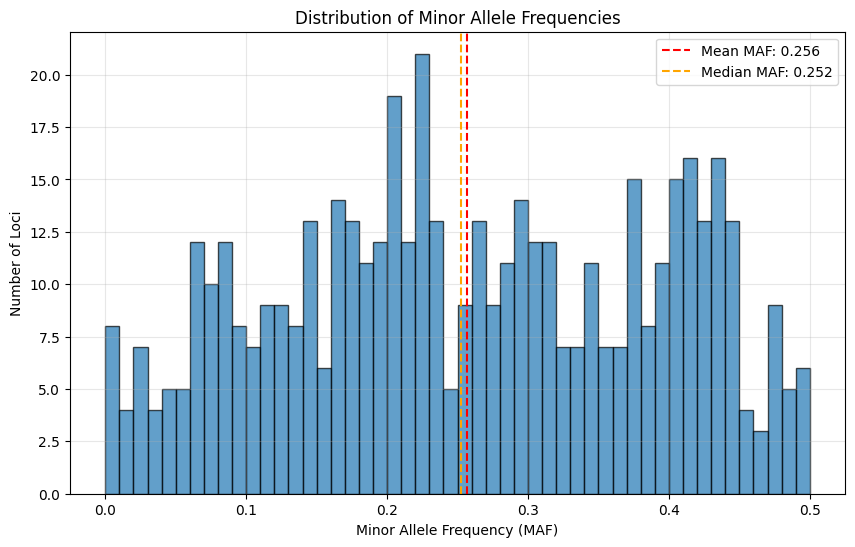

In [9]:
# Usage example with your final_pop:
maf_summary = calculate_maf_summary(final_pop.geno)
print("MAF Summary Statistics:")
for key, value in maf_summary.items():
    if key not in ['maf_per_locus', 'allele_frequencies']:
        print(f"  {key}: {value}")

# Plot the distribution
plot_maf_distribution(maf_summary)

MAF Summary Statistics:
  mean_maf: 0.2753700017929077
  median_maf: 0.2524999976158142
  min_maf: 0.07500000298023224
  max_maf: 0.5
  std_maf: 0.1182679682970047
  n_loci: 500
  n_monomorphic: 0


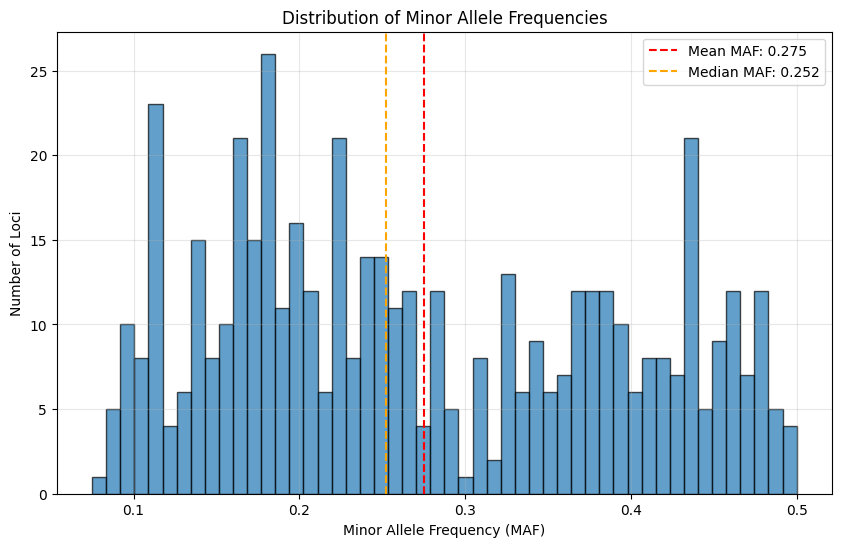

In [10]:
# Usage example with your founder_pop:
maf_summary = calculate_maf_summary(founder_pop.geno)
print("MAF Summary Statistics:")
for key, value in maf_summary.items():
    if key not in ['maf_per_locus', 'allele_frequencies']:
        print(f"  {key}: {value}")

# Plot the distribution
plot_maf_distribution(maf_summary)

Starting burn-in simulation...
Generation 0/20
  Mean GV: 10.000, Var GV: 2.000
Generation 1/20
  Population size: 2000
  Mean GV: 10.009, Var GV: 1.823
  Phenotype - mean: 10.027, var: 2.013
  Realized h2: 0.906
Generation 2/20
Generation 3/20
Generation 4/20
Generation 5/20
Generation 6/20
  Population size: 2000
  Mean GV: 10.066, Var GV: 1.526
  Phenotype - mean: 10.074, var: 1.727
  Realized h2: 0.883
Generation 7/20
Generation 8/20
Generation 9/20
Generation 10/20
Generation 11/20
  Population size: 2000
  Mean GV: 10.088, Var GV: 1.543
  Phenotype - mean: 10.085, var: 1.711
  Realized h2: 0.902
Generation 12/20
Generation 13/20
Generation 14/20
Generation 15/20
Generation 16/20
  Population size: 2000
  Mean GV: 9.931, Var GV: 1.503
  Phenotype - mean: 9.934, var: 1.668
  Realized h2: 0.901
Generation 17/20
Generation 18/20
Generation 19/20
Generation 20/20
  Population size: 2000
  Mean GV: 9.980, Var GV: 1.518
  Phenotype - mean: 9.984, var: 1.651
  Realized h2: 0.919

Burn-in

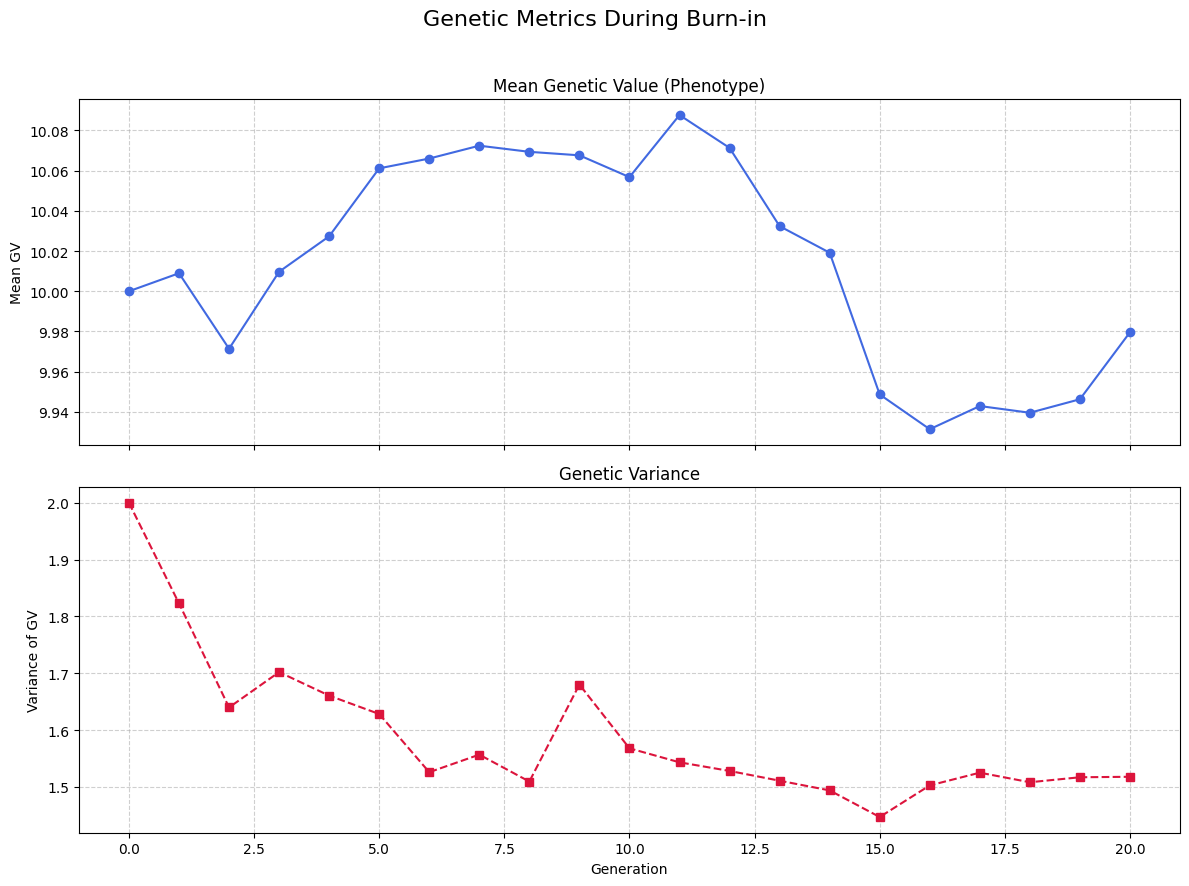


Linkage disequilibrium should now be more relevant for breeding.


In [26]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.cross import make_cross
from chewc.phenotype import set_pheno, _calculate_gvs_vectorized_alternative # Import helper for initial GV calculation

def run_burnin(key, founder_pop, sim_param, n_generations=20, pop_size=500,
               use_pheno=False, h2=0.4):
    """
    Run burn-in for specified generations using random mating and track genetic values.

    Args:
        key: JAX random key
        founder_pop: Initial population
        sim_param: Simulation parameters
        n_generations: Number of burn-in generations
        pop_size: Population size to maintain
        use_pheno: If True, set phenotypes for each generation using set_pheno
        h2: Heritability to use when setting phenotypes (only used if use_pheno=True)

    Returns:
        A tuple containing:
        - final_pop (Population): The final population after burn-in.
        - mean_gvs (list): A list of mean genetic values for each generation.
        - var_gvs (list): A list of genetic variances for each generation.
    """
    current_pop = founder_pop
    mean_gvs = []
    var_gvs = []

    # --- TRACKING: Calculate and store metrics for the founder population (Generation 0) ---
    if sim_param.traits is not None:
        # Calculate GV for the founder pop as it doesn't have it yet
        _, initial_gvs = _calculate_gvs_vectorized_alternative(
            pop=current_pop,
            traits=sim_param.traits,
            ploidy=sim_param.ploidy
        )
        mean_gvs.append(jnp.mean(initial_gvs[:, 0]))
        var_gvs.append(jnp.var(initial_gvs[:, 0]))
        print(f"Generation 0/20")
        print(f"  Mean GV: {mean_gvs[-1]:.3f}, Var GV: {var_gvs[-1]:.3f}")

    for gen in range(n_generations):
        print(f"Generation {gen + 1}/{n_generations}")

        # Split key for this generation
        key, gen_key = jax.random.split(key)
        cross_key, sex_key = jax.random.split(gen_key)

        # Create random mating plan
        n_crosses = pop_size

        # Random parent selection
        mother_indices = jax.random.choice(
            cross_key, current_pop.nInd, shape=(n_crosses,), replace=True
        )
        father_indices = jax.random.choice(
            jax.random.split(cross_key)[1], current_pop.nInd, shape=(n_crosses,), replace=True
        )
        cross_plan = jnp.stack([mother_indices, father_indices], axis=1)

        # Make crosses to create next generation
        next_id_start = jnp.max(current_pop.id) + 1
        next_pop = make_cross(
            key=cross_key, pop=current_pop, cross_plan=cross_plan,
            sp=sim_param, next_id_start=int(next_id_start)
        )

        # Set phenotypes and calculate genetic values for the new generation
        if use_pheno and sim_param.traits is not None:
            key, pheno_key = jax.random.split(key)
            next_pop = set_pheno(
                key=pheno_key, pop=next_pop, traits=sim_param.traits,
                ploidy=sim_param.ploidy, h2=jnp.array([h2])
            )

        # Update current population
        current_pop = next_pop

        # --- TRACKING: Record metrics for the current generation ---
        if current_pop.gv is not None:
            mean_gvs.append(jnp.mean(current_pop.gv[:, 0]))
            var_gvs.append(jnp.var(current_pop.gv[:, 0]))

        # Print some basic stats
        if gen % 5 == 0 or gen == n_generations - 1:
            print(f"  Population size: {current_pop.nInd}")
            if current_pop.gv is not None:
                 print(f"  Mean GV: {mean_gvs[-1]:.3f}, Var GV: {var_gvs[-1]:.3f}")
            if use_pheno and current_pop.pheno.shape[1] > 0:
                pheno_mean = jnp.mean(current_pop.pheno[:, 0])
                pheno_var = jnp.var(current_pop.pheno[:, 0])
                print(f"  Phenotype - mean: {pheno_mean:.3f}, var: {pheno_var:.3f}")
                if current_pop.bv is not None:
                    bv_var = jnp.var(current_pop.bv[:, 0])
                    realized_h2 = bv_var / pheno_var if pheno_var > 0 else 0
                    print(f"  Realized h2: {realized_h2:.3f}")

    return current_pop, mean_gvs, var_gvs

# --- Simulation Setup (Unchanged) ---
pop_size = 2000
n_chr = 5
n_loci_per_chr = 100

key = jax.random.PRNGKey(42)
key, setup_key = jax.random.split(key)

founder_pop, genetic_map = msprime_pop(
    key=setup_key, n_ind=pop_size, n_loci_per_chr=n_loci_per_chr, n_chr=n_chr
)

sim_param = SimParam.from_founder_pop(founder_pop, genetic_map)

key, trait_key = jax.random.split(key)
sim_param_with_trait = add_trait_a(
    key=trait_key, founder_pop=founder_pop, sim_param=sim_param,
    n_qtl_per_chr=n_loci_per_chr, # All loci as QTL
    mean=jnp.array([10.0]), var=jnp.array([2.0])
)

print("Starting burn-in simulation...")

# --- Run Simulation (Modified to capture tracking results) ---
key, burnin_key = jax.random.split(key)
final_pop, mean_gvs, var_gvs = run_burnin(
    key=burnin_key,
    founder_pop=founder_pop,
    sim_param=sim_param_with_trait,
    n_generations=20,
    pop_size=pop_size,
    use_pheno=True,
    h2=0.9
)

print(f"\nBurn-in complete!")
print(f"Final population size: {final_pop.nInd}")

# --- NEW: Visualize the results ---
generations = np.arange(len(mean_gvs)) # Generations from 0 to n_generations

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Genetic Metrics During Burn-in', fontsize=16)

# Plot Mean Genetic Value
ax1.plot(generations, mean_gvs, marker='o', linestyle='-', color='royalblue')
ax1.set_title('Mean Genetic Value (Phenotype)')
ax1.set_ylabel('Mean GV')
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot Genetic Variance
ax2.plot(generations, var_gvs, marker='s', linestyle='--', color='crimson')
ax2.set_title('Genetic Variance')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Variance of GV')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"\nLinkage disequilibrium should now be more relevant for breeding.")